# B(N)PO :: 3rd iteration of wheeler project for Reacher UnityML environment
---

### 1. Import the Necessary Packages

In [1]:
import torch
from alchemy.agent import Agent, BrainDescription
from alchemy.env import Env

import model

import matplotlib.pyplot as plt
%matplotlib inline

### 2. Load CONFIG :: TODO -> more implicit config

In [2]:
TOTAL_ENV = 20
GOAL_SIZE = 3
STATE_SIZE = 33 - GOAL_SIZE
ACTION_SIZE = 4
N_STEP = 4#10

N_HISTORY = 1#4#
N_ACTORS = 1
MAX_STEPS = 70

DEVICE = "cpu"

### 3. Load Environment

In [3]:
from tasks.uml_reacher_moving_mrocs import StaticReacherProxy, N_REWARDS, f_reward
from utils.task import Task

task = Task(StaticReacherProxy, 30.)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 4. Encoders

In [4]:
from utils.encoders import *
from utils.rnn import FasterGRUEncoder

def Encoder():
    return GlobalNormalizer(STATE_SIZE, N_HISTORY)
    return StackedEncoder(
            GlobalNormalizer(STATE_SIZE, N_HISTORY),
            FasterGRUEncoder(STATE_SIZE, N_HISTORY, 2 * 48, 2))

def GoalEncoder():
    return GoalGlobalNorm(GOAL_SIZE)

encoder = Encoder()
encoder.share_memory()
goal_encoder = GoalEncoder()
goal_encoder.share_memory()

GoalGlobalNorm(
  (norm): Normalizer()
)

### 4. Actor + Critic models

In [5]:
def Actor(encoder, action_size):
    nes_layers = [encoder.out_size() + GOAL_SIZE, 400, 300, action_size]
    return lambda: model.ActorFactory(
        nes_layers, action_size=action_size, 
        f_mean_clip=lambda x: x, f_scale_clip=torch.tanh,
        device=DEVICE)

def Critic(encoder, action_size, n_rewards):
    return lambda: model.Critic(N_ACTORS, n_rewards, encoder.out_size(), action_size)

### 5. Debug out callback, post priting graph + meassuring time

In [6]:
from timebudget import timebudget
try:
    timebudget.set_quiet()
except:
    pass
import time
env_start = time.time()
env_counter = 0
def callback(bot, task, test_scores, learn_scores, seeds, total):
    global env_start, env_counter
    env_counter += 1
    if test_scores is None:
        return
    print("\n\t [", env_counter, "] < %.2f"%(time.time()-env_start), "sec > TEST ==> ", test_scores, "exploring score:", learn_scores.mean())
    timebudget.report("_clocked_step")

### 6. HER implementation ~ buffer specialization

In [7]:
from utils.her import HER, CreditAssignment

import random
class ReacherHER(HER):
    def update_goal(self, rewards, goals, states, states_1, n_goals, n_states, actions, her_step_inds, n_steps):
        MAX_HER_STEP = 1
        gid = 0
        delta = 0
        h_rewards = rewards.clone()
        h_goals = goals.clone()
        h_n_goals = n_goals.clone()
        for i, (g, s, n_g, n, u, step) in enumerate(zip(goals, states, n_goals, n_states, her_step_inds, n_steps)):
            her_active = bool(sum(her_step_inds[(i-MAX_HER_STEP) if MAX_HER_STEP < i else 0:i]))

            if not her_active and u: # we will set-up new goal
                gid = random.randint(0, len(goals[:-self.n_step-MAX_HER_STEP])-1)
                delta = 0

            if her_active or u:
                if gid+delta+self.n_step<len(goals) and i<len(goals)-self.n_step:# previous state was assigned HER
                    g, n_g = goals[gid+delta], goals[gid+delta+step]
                delta += 1

            h_rewards[i] = torch.tensor(f_reward(s, n, g, None, True, None, None))
            h_goals[i] = g.clone()
            h_n_goals[i] = n_g.clone()
        return ( h_rewards, h_goals, states, h_n_goals, n_states )

def ReacherCreditAssignment(cind, gae, n_step, floating_step, gamma, gae_tau, her_delay):
    print("HER IS TURNED OFF!!")
    return CreditAssignment(cind=cind, gae=gae, n_step=n_step, floating_step=floating_step, gamma=gamma, gae_tau=gae_tau)

### 7. Setup agent ( memory + credit assignment + environment and algorithm ~ actor-critic )

In [8]:
from utils.memory import Memory
from utils.memlocal import MemoryBoost

def new_agent(
    her, brains, 
    goal_encoder, encoder, freeze_delta, freeze_count, 
    action_size, n_rewards, n_step, max_steps,
    detach_actors, detach_critics, stable_probs,
    good_reach=1, model_path="checkpoints", save=False, load=False,
    eval_delay=20
    ):
    
    credit_assign = [ ReacherHER(
        cind=i, gae=True, n_step=n_step, floating_step=True, gamma=.99, gae_tau=.95, her_delay=h) if h else ReacherCreditAssignment(
        cind=i, gae=True, n_step=n_step, floating_step=True, gamma=.99, gae_tau=.95, her_delay=None) for i, h in enumerate(her) ]
    
    # g, s, f, a, p, r, n_g, n_s, n_f, c, d
    memory = Memory(20 * max_steps * 200, recalc_delay=5, chunks=[
        GOAL_SIZE, STATE_SIZE, encoder.features_n(), 3*action_size, action_size, 
        n_rewards, GOAL_SIZE, STATE_SIZE, encoder.features_n(), n_rewards, 1], 
                    ep_draw=10, device=DEVICE)

    experience = lambda descs, brain: MemoryBoost(descs, memory, credit_assign, brain, n_step, good_reach)

    agent = Agent(
        DEVICE,
        brains, experience,
        Actor=Actor(encoder, action_size), Critic=Critic(encoder, action_size, n_rewards), 
        goal_encoder=goal_encoder, encoder=encoder, 
        n_agents=1, detach_actors=detach_actors, detach_critics=detach_critics, stable_probs=stable_probs,
        resample_delay=10, min_step=n_step*2,
        state_size=STATE_SIZE, action_size=action_size,
        freeze_delta=freeze_delta, freeze_count=freeze_count,
        lr_critic=5e-5, clip_norm=1.,
        model_path=model_path, save=save, load=load, delay=10
    )

    # defined above
    env = Env(agent, 
            total_envs=TOTAL_ENV, n_history=N_HISTORY, history_features=encoder.features_n(), state_size=encoder.in_size(),
            n_step=n_step, send_delta=max_steps,
            eval_limit=10, eval_ratio=.5, max_n_episode=max_steps, eval_delay=eval_delay,
            mcts_random_cap=100000, mcts_rounds=1, mcts_random_ratio=10, limit=2000)
    
    return agent, env

## 8. in depth setup of ALGORITHMs used ( bpo ~> ppo / ddpg / natural )

In [9]:
BS = 2048

bpo_brain = [
    
        BrainDescription( # master :: PPO
            memory_size=20 * MAX_STEPS * 10, batch_size=1024, 
            
            optim_pool_size=(MAX_STEPS * 40 * 6 * 6 * 1) // 3,
            optim_epochs=1, optim_batch_size=1*BS, recalc_delay=2,
            
            lr_actor=1e-4, learning_delay=1*N_STEP, learning_repeat=6,

            sync_delta_a=1, sync_delta_c=1, tau_actor=1e-1, tau_critic=0,
            bellman=False, ppo_eps=2e-1, natural=False, mean_only=False, separate_actors=False),
    
        BrainDescription( # master :: PPO
            memory_size=20 * MAX_STEPS * 6, batch_size=BS, 
            
            optim_pool_size=(MAX_STEPS * 80 * 20) // 3,
            optim_epochs=1, optim_batch_size=1*BS, recalc_delay=2,
            
            lr_actor=1e-4, learning_delay=3*MAX_STEPS, learning_repeat=20, # train here more will do also job!
            sync_delta_a=1, sync_delta_c=1, tau_actor=1, tau_critic=1,
            bellman=False, ppo_eps=2e-1, natural=False, mean_only=False, separate_actors=False),

]
print("\nB(N)PO: \n", [b for b in bpo_brain])


B(N)PO: 
 [[14000, '<- memory_size;', 1024, '<- batch_size;', 1, '<- optim_epochs;', 2048, '<- optim_batch_size;', 33600, '<- optim_pool_size;', 2, '<- recalc_delay;', 1, '<- sync_delta_a;', 1, '<- sync_delta_c;', 4, '<- learning_delay;', 6, '<- learning_repeat;', 0.0001, '<- lr_actor;', 0.1, '<- tau_actor;', 0, '<- tau_critic;', 0.2, '<- ppo_eps;', False, '<- natural;', False, '<- mean_only;'], [8400, '<- memory_size;', 2048, '<- batch_size;', 1, '<- optim_epochs;', 2048, '<- optim_batch_size;', 37333, '<- optim_pool_size;', 2, '<- recalc_delay;', 1, '<- sync_delta_a;', 1, '<- sync_delta_c;', 210, '<- learning_delay;', 20, '<- learning_repeat;', 0.0001, '<- lr_actor;', 1, '<- tau_actor;', 1, '<- tau_critic;', 0.2, '<- ppo_eps;', False, '<- natural;', False, '<- mean_only;']]


## 9. LEARN!

HER IS TURNED OFF!!
HER IS TURNED OFF!!


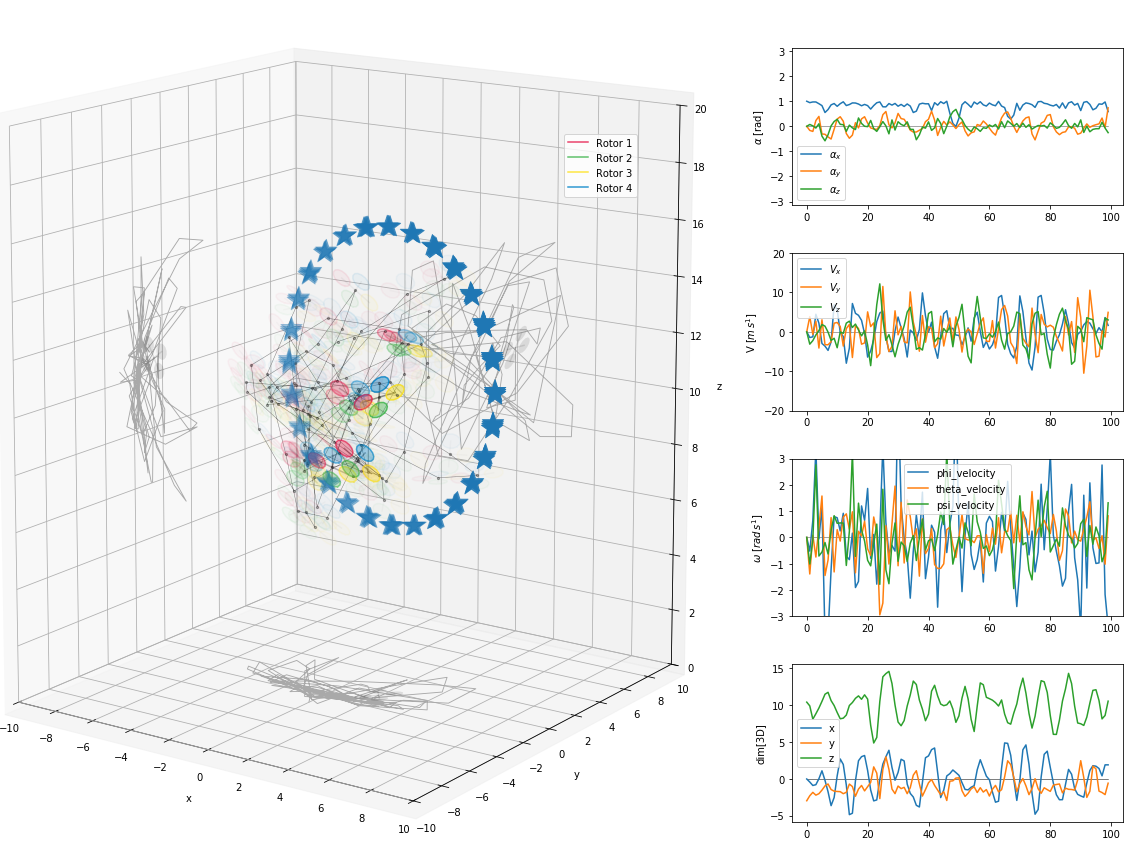

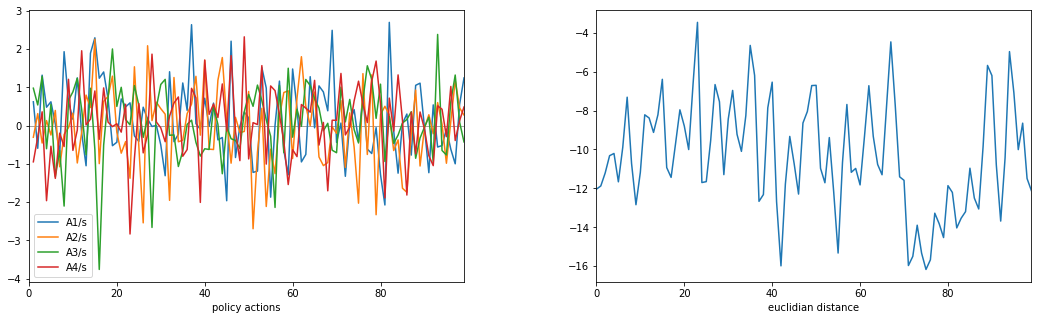

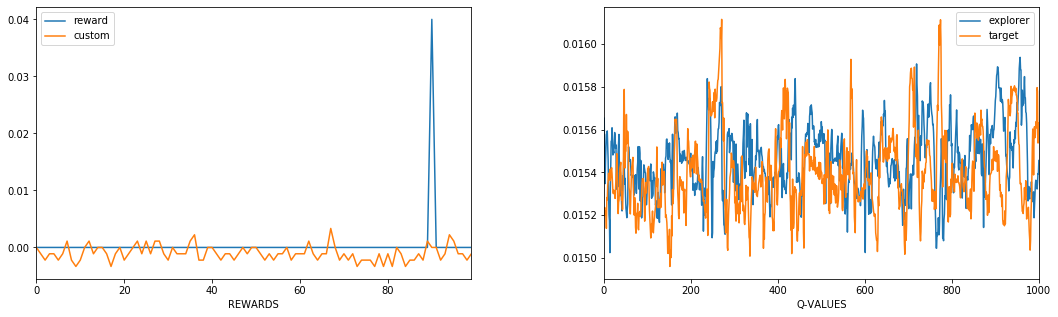

[   15>  1015:: 0] steps =   35, max_step =  70/ 70, reward=-0.012333 <action=tensor([-3.6918, -7.1151,  4.4653, -2.6154])>                                    PPO too off, from sampled actions, policies problems!!  20 1294 tensor(-8.6598, grad_fn=<MeanBackward0>) tensor(-1.3953)
[   15>  1031:: 0] steps =   51, max_step =  70/ 70, reward=-0.014778 <action=tensor([-3.1096, -8.9780,  0.6786, -2.8910])>                    PPO too off, from sampled actions, policies problems!!  40 1294 tensor(-7.7550, grad_fn=<MeanBackward0>) tensor(-1.3897)
[   15>  1043:: 0] steps =   63, max_step =  70/ 70, reward=-0.016444 <action=tensor([ -2.1800, -11.9990,   1.2488,  -3.6675])>                    PPO too off, from sampled actions, policies problems!!  60 1294 tensor(-11.7782, grad_fn=<MeanBackward0>) tensor(-1.4181)
[   15>  1049:: 0] steps =   69, max_step =  70/ 70, reward=-0.015944 <action=tensor([-2.4355, -9.2490,  1.6528, -2.5636])>                        PPO too off, from sampled actions, polic

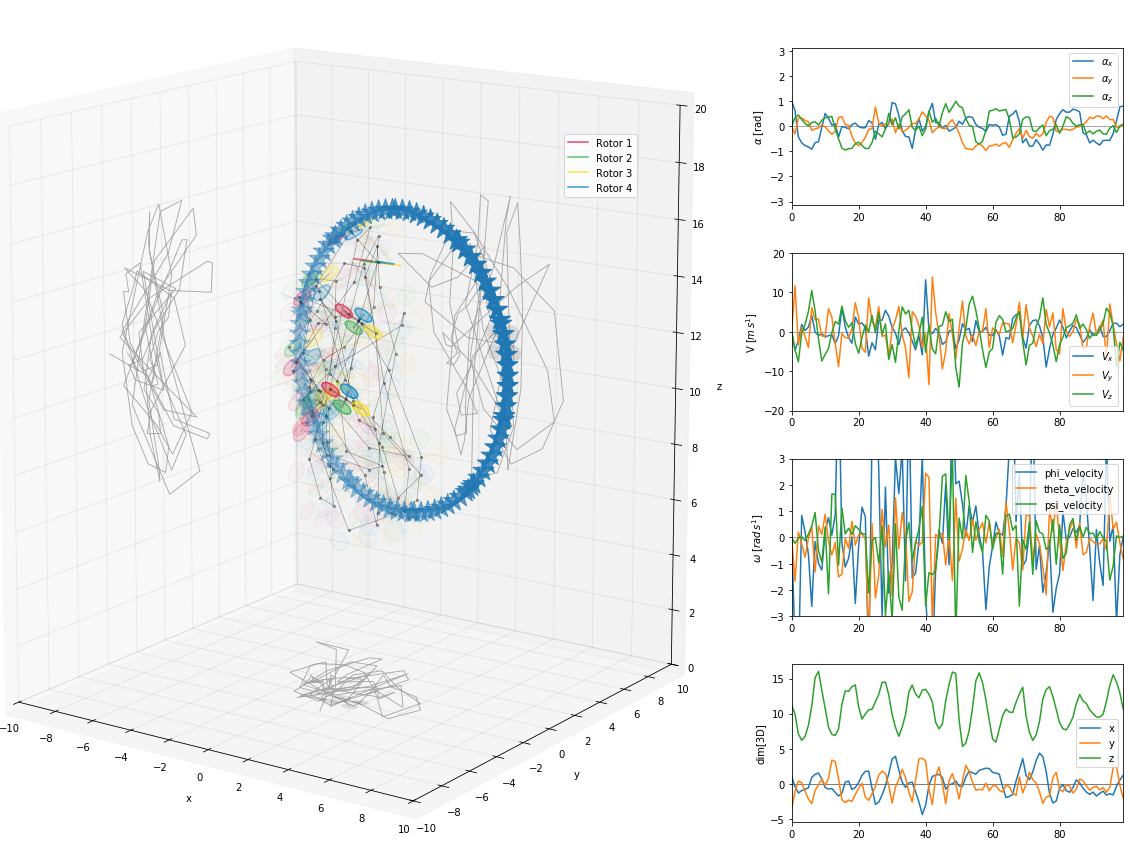

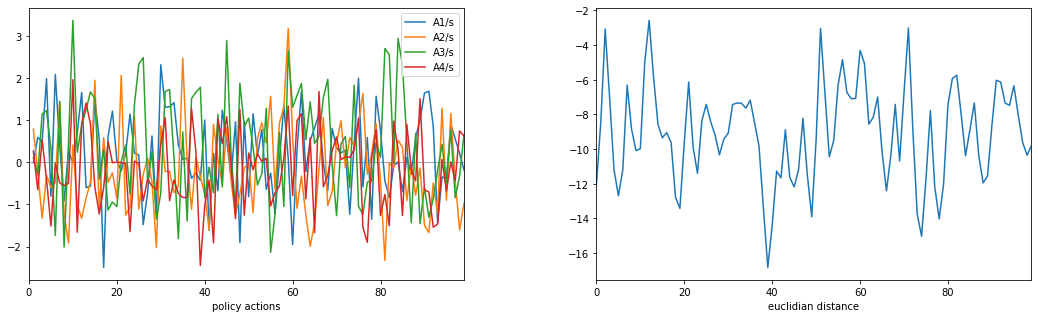

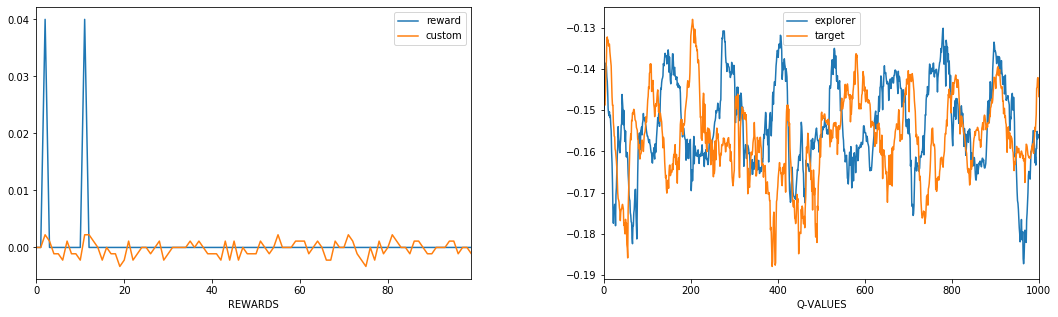

[   39>  2729:: 0] steps =   69, max_step =  70/ 70, reward=0.032278 <action=tensor([ 1.0639, -3.6983, -1.9530, -1.4122])>                                     
	 [ 39 ] < 2079.08 sec > TEST ==>  [[tensor(2.5130)], [tensor(3.0330)]] exploring score: tensor(0.0327)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   720.60ms/cyc @     1.0 calls/cyc
              learn-round: 100.0%   720.47ms/cyc @     1.5 calls/cyc
                    learn: 100.0%   720.42ms/cyc @     1.5 calls/cyc
        FullMemory-sample:  77.5%   558.25ms/cyc @     0.5 calls/cyc
            _push_to_fast:  61.8%   445.23ms/cyc @   104.9 calls/cyc
                 __call__:  30.4%   219.33ms/cyc @   105.2 calls/cyc
                   _learn:  28.5%   205.51ms/cyc @     1.5 calls/cyc
        FastMemory-sample:  22.5%   162.07ms/cyc @     1.0 calls/cyc
                 backprop:  14.0%   100.53ms/cyc @     3.0 calls/cyc
             recalc_feats:   0.9%     6.26ms/cyc @    17.7 calls/cyc
 

[  199> 13929:: 0] steps =   69, max_step =  70/ 70, reward=0.136611 <action=tensor([-2.3122,  1.6803,  2.2020,  0.4128])>                                    
	 [ 199 ] < 11402.96 sec > TEST ==>  [[tensor(21.4935)], [tensor(17.8320)]] exploring score: tensor(0.1391)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   763.73ms/cyc @     1.0 calls/cyc
              learn-round: 100.0%   763.60ms/cyc @     1.6 calls/cyc
                    learn: 100.0%   763.54ms/cyc @     1.6 calls/cyc
        FullMemory-sample:  78.4%   599.02ms/cyc @     0.5 calls/cyc
            _push_to_fast:  62.7%   479.16ms/cyc @   111.1 calls/cyc
                 __call__:  30.8%   235.33ms/cyc @   111.4 calls/cyc
                   _learn:  27.5%   210.10ms/cyc @     1.6 calls/cyc
        FastMemory-sample:  21.5%   164.43ms/cyc @     1.1 calls/cyc
                 backprop:  13.6%   104.01ms/cyc @     3.2 calls/cyc
                    _push:   3.0%    22.71ms/cyc @     0.3 calls/cy

[  359> 25129:: 0] steps =   69, max_step =  70/ 70, reward=0.148056 <action=tensor([ 0.8301, -0.3576,  0.6522,  0.9602])>                                    
	 [ 359 ] < 20654.07 sec > TEST ==>  [[tensor(22.3990)], [tensor(23.0040)]] exploring score: tensor(0.1508)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   761.84ms/cyc @     1.0 calls/cyc
              learn-round: 100.0%   761.70ms/cyc @     1.6 calls/cyc
                    learn: 100.0%   761.65ms/cyc @     1.6 calls/cyc
        FullMemory-sample:  78.4%   597.00ms/cyc @     0.5 calls/cyc
            _push_to_fast:  62.7%   477.90ms/cyc @   110.7 calls/cyc
                 __call__:  30.7%   234.15ms/cyc @   111.0 calls/cyc
                   _learn:  27.6%   209.89ms/cyc @     1.6 calls/cyc
        FastMemory-sample:  21.6%   164.56ms/cyc @     1.1 calls/cyc
                 backprop:  13.7%   104.01ms/cyc @     3.2 calls/cyc
                    _push:   3.8%    28.66ms/cyc @     0.3 calls/cy

[  519> 36329:: 0] steps =   69, max_step =  70/ 70, reward=0.150278 <action=tensor([0.3849, 1.2160, 0.3814, 0.9351])>                                         
	 [ 519 ] < 30034.48 sec > TEST ==>  [[tensor(24.9960)], [tensor(24.1085)]] exploring score: tensor(0.1531)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   764.14ms/cyc @     1.0 calls/cyc
              learn-round: 100.0%   764.01ms/cyc @     1.6 calls/cyc
                    learn: 100.0%   763.95ms/cyc @     1.6 calls/cyc
        FullMemory-sample:  78.3%   598.69ms/cyc @     0.5 calls/cyc
            _push_to_fast:  62.8%   479.55ms/cyc @   110.8 calls/cyc
                 __call__:  30.7%   234.71ms/cyc @   111.1 calls/cyc
                   _learn:  27.5%   210.39ms/cyc @     1.6 calls/cyc
        FastMemory-sample:  21.6%   165.18ms/cyc @     1.1 calls/cyc
                 backprop:  13.6%   104.19ms/cyc @     3.2 calls/cyc
                    _push:   4.1%    31.36ms/cyc @     0.3 calls/c

[  679> 47529:: 0] steps =   69, max_step =  70/ 70, reward=0.160000 <action=tensor([ 0.7781,  0.1143, -1.9832,  0.0958])>                                    
	 [ 679 ] < 39413.50 sec > TEST ==>  [[tensor(24.2300)], [tensor(26.4130)]] exploring score: tensor(0.1629)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   765.46ms/cyc @     1.0 calls/cyc
              learn-round: 100.0%   765.33ms/cyc @     1.6 calls/cyc
                    learn: 100.0%   765.27ms/cyc @     1.6 calls/cyc
        FullMemory-sample:  78.4%   600.34ms/cyc @     0.5 calls/cyc
            _push_to_fast:  62.9%   481.15ms/cyc @   111.1 calls/cyc
                 __call__:  30.7%   235.29ms/cyc @   111.3 calls/cyc
                   _learn:  27.5%   210.13ms/cyc @     1.6 calls/cyc
        FastMemory-sample:  21.5%   164.85ms/cyc @     1.1 calls/cyc
                 backprop:  13.6%   104.09ms/cyc @     3.2 calls/cyc
                    _push:   4.3%    32.70ms/cyc @     0.3 calls/cy

[  839> 58729:: 0] steps =   69, max_step =  70/ 70, reward=0.164944 <action=tensor([ 0.7748,  0.0759, -0.2763,  0.4376])>                                     
	 [ 839 ] < 48978.63 sec > TEST ==>  [[tensor(29.2640)], [tensor(23.7195)]] exploring score: tensor(0.1680)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   768.41ms/cyc @     1.0 calls/cyc
              learn-round: 100.0%   768.28ms/cyc @     1.6 calls/cyc
                    learn: 100.0%   768.22ms/cyc @     1.6 calls/cyc
        FullMemory-sample:  78.5%   603.24ms/cyc @     0.5 calls/cyc
            _push_to_fast:  62.9%   483.66ms/cyc @   111.3 calls/cyc
                 __call__:  30.8%   236.41ms/cyc @   111.6 calls/cyc
                   _learn:  27.4%   210.34ms/cyc @     1.6 calls/cyc
        FastMemory-sample:  21.5%   164.89ms/cyc @     1.1 calls/cyc
                 backprop:  13.6%   104.21ms/cyc @     3.2 calls/cyc
                    _push:   4.4%    33.53ms/cyc @     0.3 calls/c

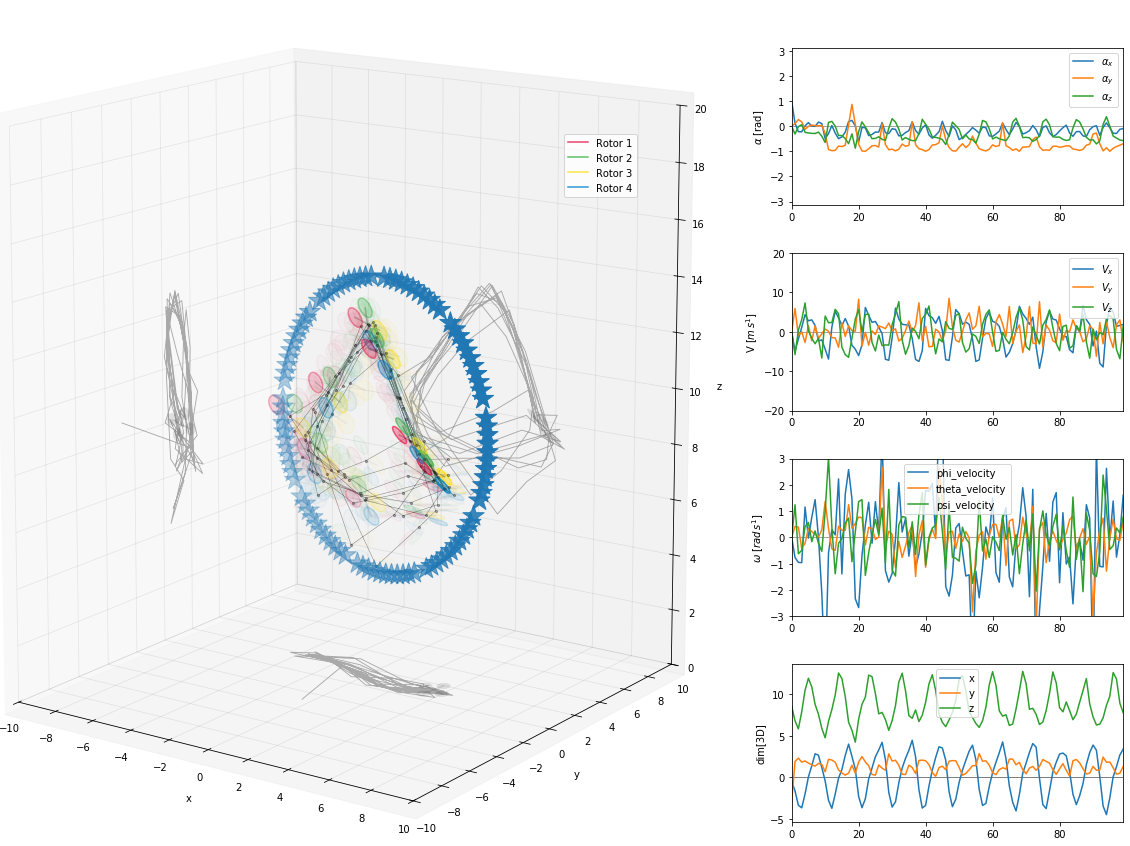

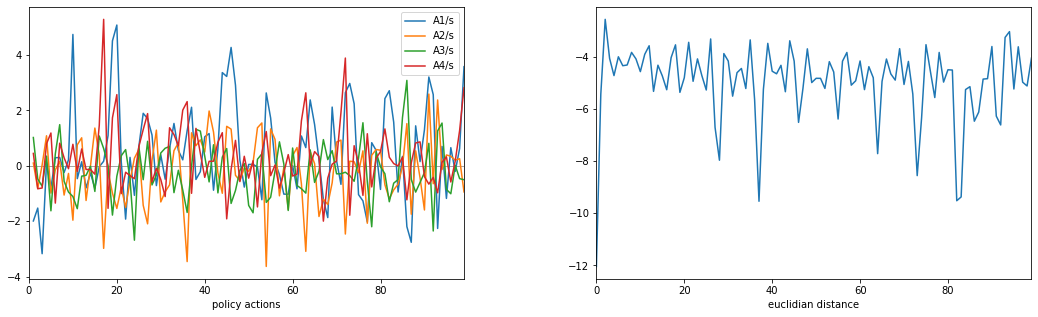

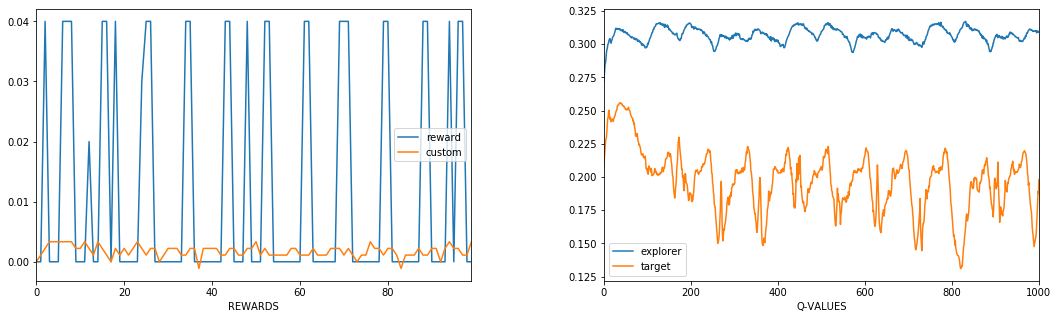

[  879> 61529:: 0] steps =   69, max_step =  70/ 70, reward=0.160167 <action=tensor([ 4.4747, -1.2474, -0.5521,  0.4776])>                                     
	 [ 879 ] < 51347.94 sec > TEST ==>  [[tensor(27.9010)], [tensor(27.4770)]] exploring score: tensor(0.1631)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   768.76ms/cyc @     1.0 calls/cyc
              learn-round: 100.0%   768.63ms/cyc @     1.6 calls/cyc
                    learn: 100.0%   768.58ms/cyc @     1.6 calls/cyc
        FullMemory-sample:  78.5%   603.39ms/cyc @     0.5 calls/cyc
            _push_to_fast:  62.9%   483.81ms/cyc @   111.3 calls/cyc
                 __call__:  30.8%   236.49ms/cyc @   111.6 calls/cyc
                   _learn:  27.4%   210.50ms/cyc @     1.6 calls/cyc
        FastMemory-sample:  21.5%   165.10ms/cyc @     1.1 calls/cyc
                 backprop:  13.6%   104.28ms/cyc @     3.2 calls/cyc
                    _push:   4.4%    33.76ms/cyc @     0.3 calls/c

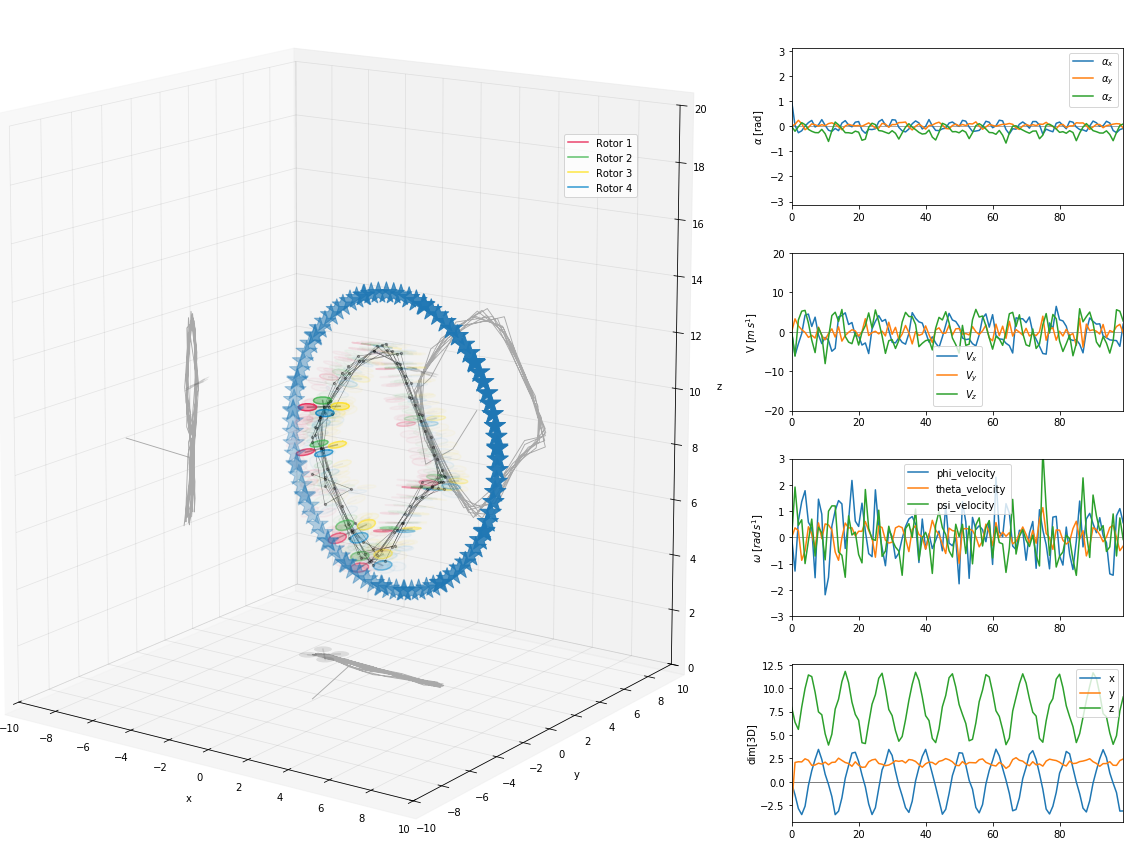

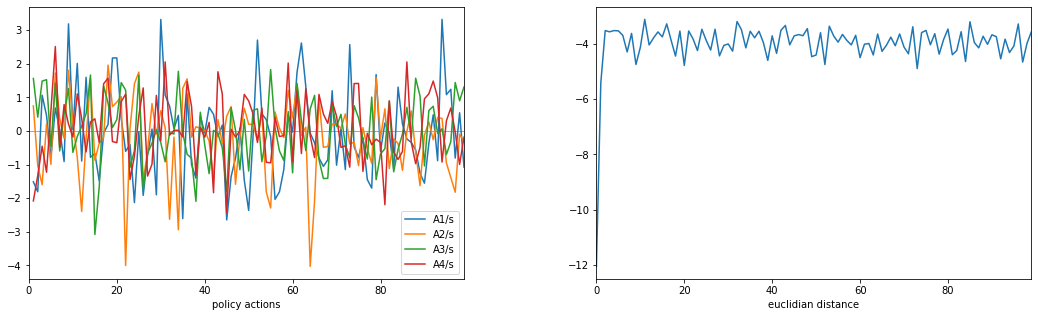

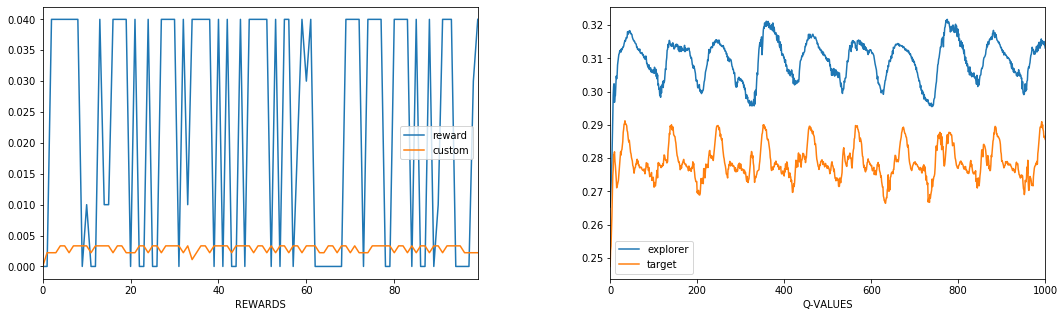

[  899> 62929:: 0] steps =   69, max_step =  70/ 70, reward=0.164833 <action=tensor([-2.3097, -1.3660, -2.3056,  0.9100])>                                    
 environment solved!  31.839374288334493 [array([31.5158993 , 32.16284928])]
[[tensor(31.8060), tensor(30.3940), tensor(32.5020), tensor(31.6945), tensor(31.7900), tensor(32.3185), tensor(30.6335), tensor(31.3975), tensor(32.6505), tensor(29.9725)], [tensor(32.7805), tensor(32.3455), tensor(33.4310), tensor(32.2110), tensor(31.3400), tensor(31.6150), tensor(32.6760), tensor(32.7620), tensor(32.7300), tensor(29.7375)]]


In [10]:
agent, env = new_agent(
    [0, 0], bpo_brain, 
    goal_encoder, encoder, freeze_delta=3, freeze_count=3, 
    action_size=4, n_rewards=N_REWARDS, n_step=N_STEP, max_steps=MAX_STEPS,
    detach_actors=True, detach_critics=False, stable_probs=False,
    good_reach=1, model_path="checkpoints", save=True, load=False
    )
scores = env.start(task, callback)

In [11]:
losses = agent.brain.losses
scores_ex = scores[1:]
scores = np.asarray(scores_ex).flatten()
losses_ex = losses
losses = np.vstack(losses_ex)[::len(losses_ex)//200]

### 10. Plot training reward + loss

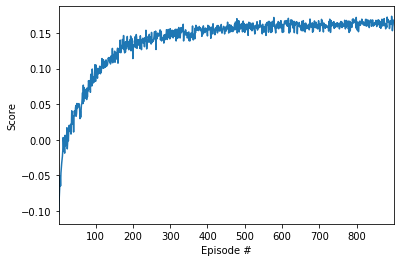

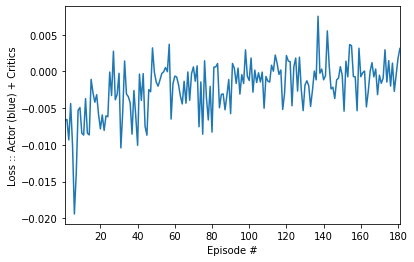

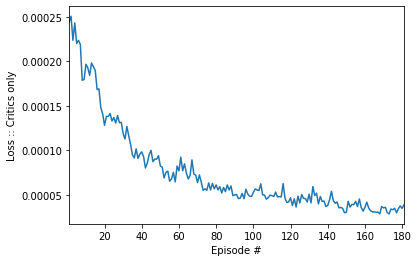

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show() 

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(losses) - len(losses) // 10+1), losses[len(losses) // 10:, 0])
plt.ylabel('Loss :: Actor (blue) + Critics')
plt.xlabel('Episode #')
plt.show() 

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(losses) - len(losses) // 10+1), losses[len(losses) // 10:, 1:])
plt.ylabel('Loss :: Critics only')
plt.xlabel('Episode #')
plt.show() 

### 11. Reload trained agent

In [13]:
agent.sync_target(0, [])
agent.sync_explorer(0, [])

### 12. Test visuals - TARGET


 environment solved!  32.37807427629362 [array([32.14594928, 32.61019927])]
[[tensor(31.1190), tensor(32.7970), tensor(32.1670), tensor(33.6770), tensor(33.7040), tensor(30.9595), tensor(31.4500), tensor(32.0465), tensor(33.6455), tensor(29.8940)], [tensor(33.3695), tensor(31.2415), tensor(32.7845), tensor(33.1065), tensor(33.8085), tensor(33.1370), tensor(32.5570), tensor(31.4010), tensor(31.9325), tensor(32.7640)]]

 environment solved!  31.791674289400685 [array([31.2816493 , 32.30169928])]
[[tensor(31.0240), tensor(31.6880), tensor(32.6100), tensor(30.9045), tensor(30.7310), tensor(30.6390), tensor(32.2175), tensor(32.0710), tensor(28.3460), tensor(32.5855)], [tensor(30.9275), tensor(32.5185), tensor(33.2770), tensor(31.1655), tensor(33.1160), tensor(33.1300), tensor(31.5225), tensor(33.7055), tensor(32.1695), tensor(31.4850)]]

 environment solved!  32.02709928413853 [array([31.91919929, 32.13499928])]
[[tensor(32.5320), tensor(31.6185), tensor(32.2270), tensor(29.3070), tensor(3

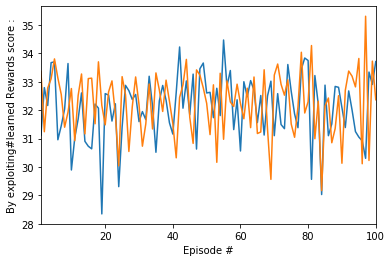

In [14]:
rewards = [[], []]
while len(rewards[0]) < 100:
    success, scores = env.evaluate(task)
    [ rewards[i].extend(score) for i, score in enumerate(scores) ]
        
print("mean rewards : ", np.mean(rewards), np.mean(rewards, 1))
fig = plt.figure()
ax = fig.add_subplot(111)
for r in rewards:
    plt.plot(np.arange(1, len(r)+1), r)
plt.ylabel('By exploiting#learned Rewards score :')
plt.xlabel('Episode #')
plt.show()

### 13. Test visuals - EXPLORER


 environment solved!  31.601174293658687 [array([31.59739929, 31.60494929])]
[[tensor(32.0710), tensor(31.7645), tensor(30.7080), tensor(31.5705), tensor(32.1685), tensor(31.4545), tensor(31.1080), tensor(32.2235), tensor(32.1150), tensor(30.7905)], [tensor(32.4550), tensor(29.9810), tensor(32.0285), tensor(32.8065), tensor(29.7605), tensor(31.1615), tensor(31.4525), tensor(33.1905), tensor(30.7190), tensor(32.4945)]]

 environment solved!  31.4442242971668 [array([31.2871993 , 31.60124929])]
[[tensor(31.3265), tensor(33.0670), tensor(30.2115), tensor(31.9855), tensor(30.7120), tensor(30.6110), tensor(29.9690), tensor(31.6500), tensor(30.9530), tensor(32.3865)], [tensor(30.6560), tensor(31.5580), tensor(31.5270), tensor(32.7270), tensor(32.6720), tensor(32.1850), tensor(29.8290), tensor(33.0135), tensor(31.0480), tensor(30.7970)]]

 environment solved!  30.716574313431032 [array([30.93994931, 30.49319932])]
[[tensor(29.1920), tensor(30.8165), tensor(32.4305), tensor(30.7080), tensor(3

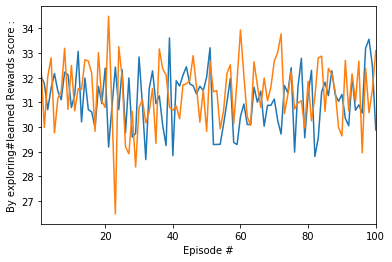

In [15]:
# for evaluation we will set target network to be explorer
agent.brain.ac_target = agent.brain.ac_explorer

rewards = [[], []]
while len(rewards[0]) < 100:
    success, scores = env.evaluate(task)
    [ rewards[i].extend(score) for i, score in enumerate(scores) ]
        
print("mean rewards : ", np.mean(rewards), np.mean(rewards, 1))
fig = plt.figure()
ax = fig.add_subplot(111)
for r in rewards:
    plt.plot(np.arange(1, len(r)+1), r)
plt.ylabel('By exploring#learned Rewards score :')
plt.xlabel('Episode #')
plt.show()